# Combined CDOM and SST Processing Pipeline

This notebook demonstrates an end-to-end pipeline for processing satellite data to derive a combined CDOM (Colored Dissolved Organic Matter) and SST (Sea Surface Temperature) metric. It performs the following steps:

1.  **Import libraries** and set up the environment.
2.  **Define constants** for CDOM calculation, bounding box, and binning.
3.  **Search for and load** the satellite NetCDF L2 files.
4.  **Extract data on a GPU** using CuPy and parallel processing via `l2_pipeline`.
5.  **Calculate CDOM and Inverted SST**, then combine them into a single metric.
6.  **Clip, bin, and plot** the rasterized combined metric.
7.  **Optionally apply selective NaN interpolation** to the binned data.

This pipeline adapts principles from `ogplotter.ipynb` using the `l2_pipeline.py` tools.

### Library Imports

The following cell imports essential libraries required for file handling, numerical operations, plotting, and the custom processing pipeline.

In [24]:
# Import essential libraries
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import binned_statistic_2d
import xarray as xr # Added for inspecting NetCDF variables
from scipy.interpolate import griddata # For interpolating SST onto RRS coordinates

import sys
sys.dont_write_bytecode = True

# Import custom pipeline components
# Attempt to reload the module to pick up recent changes
import importlib
import l2_pipeline # Import the module itself to reload
importlib.reload(l2_pipeline)
from l2_pipeline import L2DatasetLoader, GPUDataExtractor, SelectiveInterpolator

# Suppress RuntimeWarnings that can occur with NaNs in calculations, e.g. log(0)
# These are often handled by NaN filtering later or are inherent in the data.
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

### Define Constants and Parameters

This cell defines constants for the CDOM calculation algorithm, the geographical area of interest (bounding box), and parameters for binning the data.

In [25]:
# CDOM Calculation Constants (from ogplotter.ipynb)
B0 = 0.2487
B1 = 14.028
B2 = 4.085

# Geographical Bounding Box (from ogplotter.ipynb extent: [-94, 27.5, -88, 30.5])
lon_min, lon_max = -94.0, -88.0
lat_min, lat_max = 27.5, 30.5

# Binning parameters (derived from ogplotter.ipynb my_area width/height)
# These define the resolution of the final rasterized plot.
lat_bins = 200 # tall
lon_bins = 300 # wide

# --- L3 SST Data Configuration ---
# Directory for L3 SST NetCDF files. These files are expected to have variables in the root group.
data_dir_l3_sst = r"E:\satdata\MODIS_AQUA_L3_SST_THERMAL_DAILY_4KM_DAYTIME_V2019.0_Texas Louisiana Shelf_2024-06-01_2024-06-30"
# Variable name for Sea Surface Temperature in L3 files. Verify with the inspection cell below.
sst_var_name = 'sst'

# --- L2 RRS Data Configuration ---
# Directory for L2 RRS NetCDF files. These files are expected to have variables in a 'geophysical_data' group.
data_dir_l2_rrs = r"E:\satdata\Texas Louisiana Shelf_2024-06-01_2024-06-30" # Original L2 data path
# Variables for Remote Sensing Reflectance needed for CDOM calculation.
rrs_vars_list = ['Rrs_412', 'Rrs_555']
# Note: 'Rrs_667' was in the original list but is not used in the current CDOM formula.

# The 'required_variables' list is no longer used directly in this manner.
# We will load SST and RRS data separately.

### Searching for Data Files

Specify the directories containing the L3 SST and L2 RRS NetCDF satellite data files and search for them.

In [26]:
# Specify the data directory for L3 SST and search recursively for NetCDF files
# IMPORTANT: Update this path to your actual L3 SST data directory.
# data_dir_l3_sst is defined in Cell 5
nc_files_sst = glob.glob(os.path.join(data_dir_l3_sst, '**', '*.nc'), recursive=True)

if not nc_files_sst:
    print(f"Warning: No .nc files found for L3 SST in {data_dir_l3_sst}. Please check the path and data.")
else:
    print(f"Found {len(nc_files_sst)} L3 SST files.")

# Specify the data directory for L2 RRS and search recursively for NetCDF files
# IMPORTANT: Update this path to your actual L2 RRS data directory.
# data_dir_l2_rrs is defined in Cell 5
nc_files_rrs = glob.glob(os.path.join(data_dir_l2_rrs, '**', '*.nc'), recursive=True)

if not nc_files_rrs:
    print(f"Warning: No .nc files found for L2 RRS in {data_dir_l2_rrs}. Please check the path and data.")
else:
    print(f"Found {len(nc_files_rrs)} L2 RRS files.")

# Limiting files for quick testing, remove or adjust as needed for SST
# nc_files_sst = nc_files_sst[:5]
# print(f"Using {len(nc_files_sst)} L3 SST files for processing.")
# Limiting files for quick testing, remove or adjust as needed for RRS
# nc_files_rrs = nc_files_rrs[:5]
# print(f"Using {len(nc_files_rrs)} L2 RRS files for processing.")

Found 62 L3 SST files.
Found 42 L2 RRS files.


### Inspecting Variables in the SST Data

The following cell loads the first L3 SST NetCDF file found and prints its variables. Please use this information to:

1.  Confirm the correct variable name for Sea Surface Temperature (e.g., 'sst', 'sea_surface_temp', 'sea_surface_temperature').
2.  Update the `sst_var_name` in Cell 5 (the cell defining constants) if the current value (default: 'sst') is incorrect for your SST data.

In [27]:
if nc_files_sst: # Check L3 SST files
    print(f"Inspecting variables in the first L3 SST file: {nc_files_sst[0]}")
    try:
        with xr.open_dataset(nc_files_sst[0], group=None) as ds_root: # Open root group for L3
            
            def inspect_group(ds_or_group, group_path="/"):
                print(f"\nVariables in group: '{group_path}'")
                for var_name_ds in ds_or_group.variables:
                    print(f"  {var_name_ds}: {ds_or_group[var_name_ds].dims} – {ds_or_group[var_name_ds].shape} - Attributes: {ds_or_group[var_name_ds].attrs}")
                
            inspect_group(ds_root, "/") # Inspect root group

            all_found_vars_root = list(ds_root.variables)
            possible_lat_vars = [v_name for v_name in all_found_vars_root if 'lat' in v_name.lower()]
            possible_lon_vars = [v_name for v_name in all_found_vars_root if 'lon' in v_name.lower() or 'longitude' in v_name.lower()]
            
            print(f"\nPotential latitude variable names in root: {list(set(possible_lat_vars))}")
            print(f"Potential longitude variable names in root: {list(set(possible_lon_vars))}")

            possible_sst_vars = [v_name for v_name in all_found_vars_root if 'sst' in v_name.lower() or 'sea_surface' in v_name.lower() or 'temp' in v_name.lower()]
            
            current_sst_var_in_use = sst_var_name 

            if possible_sst_vars:
                print(f"\nPotential SST variable names found in root: {list(set(possible_sst_vars))}")
                if current_sst_var_in_use not in possible_sst_vars:
                    print(f"WARNING: Current SST variable '{current_sst_var_in_use}' (from Cell 5) not in potential list from root. Consider updating `sst_var_name` in Cell 5.")
                else:
                    print(f"Current SST variable '{current_sst_var_in_use}' (from Cell 5) seems plausible based on root variables.")
            else:
                print(f"\nCould not automatically identify a potential SST variable name in the root group. Please inspect the list above carefully.")
            print(f"Please verify and update `sst_var_name` (currently '{current_sst_var_in_use}') in Cell 5 if it's not the correct SST variable name for your data, and confirm coordinate variable names (typically 'lat', 'lon' for L3).")

    except Exception as e:
        print(f"Error inspecting file {nc_files_sst[0]}: {e}")
else:
    print("No L3 SST NetCDF files found to inspect. Cannot verify SST variable name or coordinates.")

Inspecting variables in the first L3 SST file: E:\satdata\MODIS_AQUA_L3_SST_THERMAL_DAILY_4KM_DAYTIME_V2019.0_Texas Louisiana Shelf_2024-06-01_2024-06-30\AQUA_MODIS.20240531.L3m.DAY.SST.sst.4km.nc

Variables in group: '/'
  sst: ('lat', 'lon') – (4320, 8640) - Attributes: {'long_name': 'Sea Surface Temperature', 'units': 'degree_C', 'standard_name': 'sea_surface_temperature', 'valid_min': -1000, 'valid_max': 10000, 'display_scale': 'linear', 'display_min': -2.0, 'display_max': 45.0}
  qual_sst: ('lat', 'lon') – (4320, 8640) - Attributes: {'long_name': 'Quality Levels, Sea Surface Temperature', 'valid_min': 0, 'valid_max': 5}
  lat: ('lat',) – (4320,) - Attributes: {'long_name': 'Latitude', 'units': 'degrees_north', 'standard_name': 'latitude', 'valid_min': -90.0, 'valid_max': 90.0}
  lon: ('lon',) – (8640,) - Attributes: {'long_name': 'Longitude', 'units': 'degrees_east', 'standard_name': 'longitude', 'valid_min': -180.0, 'valid_max': 180.0}
  palette: ('rgb', 'eightbitcolor') – (3, 25

### Loading Datasets

Using `L2DatasetLoader`, this cell loads L3 SST datasets and L2 RRS datasets separately.
For L3 SST, it's assumed variables are in the root group.
For L2 RRS, it's assumed variables are in the 'geophysical_data' group (default for L2).

In [28]:
# Load L3 SST datasets
datasets_sst = []
if nc_files_sst:
    # For L3 SST data, specify group=None to read from the root group.
    # Pass the bounding box for subsetting L3 data before GPU processing.
    # lon_min, lon_max, lat_min, lat_max are defined in Cell 5.
    sst_bbox = (lon_min, lon_max, lat_min, lat_max)
    try:
        loader_sst = L2DatasetLoader(variables=[sst_var_name], group=None, bbox=sst_bbox) # Key change: added bbox
        datasets_sst = loader_sst.load_multiple(nc_files_sst)
        print(f"Successfully loaded {len(datasets_sst)} L3 SST datasets (subsetted to bbox).")
    except Exception as e:
        print(f"Error loading L3 SST datasets: {e}. Check if L2DatasetLoader supports `group=None` or similar for root access.")
else:
    print("No L3 SST files found to load.")

# Load L2 RRS datasets
datasets_rrs = []
if nc_files_rrs:
    # For L2 RRS data, assume variables are in 'geophysical_data' group (default behavior of L2DatasetLoader)
    # No bbox needed here as L2 files are typically swaths and subsetting is less direct / not implemented for them here.
    try:
        loader_rrs = L2DatasetLoader(variables=rrs_vars_list) # Assumes default group is 'geophysical_data'
        datasets_rrs = loader_rrs.load_multiple(nc_files_rrs)
        print(f"Successfully loaded {len(datasets_rrs)} L2 RRS datasets.")
    except Exception as e:
        print(f"Error loading L2 RRS datasets: {e}")
else:
    print("No L2 RRS files found to load.")

# Initialize placeholder variables for extracted data
lon_sst_flat, lat_sst_flat, sst_vars_data_flat = np.array([]), np.array([]), {sst_var_name: np.array([])}
lon_rrs_flat, lat_rrs_flat, rrs_vars_data_flat = np.array([]), np.array([]), {var: np.array([]) for var in rrs_vars_list}

Successfully loaded 62 L3 SST datasets (subsetted to bbox).
Successfully loaded 42 L2 RRS datasets.
Successfully loaded 42 L2 RRS datasets.


### GPU Data Extraction

This cell leverages the GPU (if available and CuPy is installed) via `GPUDataExtractor` to extract and filter latitude, longitude, and variable data from the loaded L3 SST and L2 RRS datasets.

In [29]:
# Extract L3 SST data
if datasets_sst:
    try:
        extractor_sst = GPUDataExtractor(variables=[sst_var_name])
        lon_sst_flat, lat_sst_flat, sst_vars_data_flat = extractor_sst.extract(datasets_sst)
        print(f"L3 SST data extraction complete. Extracted {len(lon_sst_flat)} data points.")
        
        # Print shapes to verify extraction using native coordinates
        print(f"  Shape of lon_sst_flat: {lon_sst_flat.shape}")
        print(f"  Shape of lat_sst_flat: {lat_sst_flat.shape}")
        if sst_var_name in sst_vars_data_flat:
            print(f"  Shape of sst_vars_data_flat['{sst_var_name}']: {sst_vars_data_flat[sst_var_name].shape}")

        if sst_var_name not in sst_vars_data_flat or sst_vars_data_flat[sst_var_name].size == 0:
            print(f"Warning: SST variable '{sst_var_name}' not found or empty in extracted L3 data.")
            if sst_var_name not in sst_vars_data_flat: sst_vars_data_flat[sst_var_name] = np.array([])
    except Exception as e:
        print(f"Error during L3 SST data extraction: {e}")
        lon_sst_flat, lat_sst_flat, sst_vars_data_flat = np.array([]), np.array([]), {sst_var_name: np.array([])}
else:
    print("No L3 SST datasets loaded, skipping L3 SST data extraction.")
    lon_sst_flat, lat_sst_flat, sst_vars_data_flat = np.array([]), np.array([]), {sst_var_name: np.array([])}

# Extract L2 RRS data
if datasets_rrs:
    try:
        extractor_rrs = GPUDataExtractor(variables=rrs_vars_list)
        lon_rrs_flat, lat_rrs_flat, rrs_vars_data_flat = extractor_rrs.extract(datasets_rrs)
        print(f"L2 RRS data extraction complete. Extracted {len(lon_rrs_flat)} data points.")
        for var in rrs_vars_list:
            if var not in rrs_vars_data_flat or rrs_vars_data_flat[var].size == 0:
                 print(f"Warning: RRS variable '{var}' not found or empty in extracted L2 data.")
                 if var not in rrs_vars_data_flat: rrs_vars_data_flat[var] = np.array([]) # Ensure key exists
    except Exception as e:
        print(f"Error during L2 RRS data extraction: {e}")
        lon_rrs_flat, lat_rrs_flat, rrs_vars_data_flat = np.array([]), np.array([]), {var: np.array([]) for var in rrs_vars_list}
else:
    print("No L2 RRS datasets loaded, skipping L2 RRS data extraction.")
    lon_rrs_flat, lat_rrs_flat, rrs_vars_data_flat = np.array([]), np.array([]), {var: np.array([]) for var in rrs_vars_list}

L3 SST data extraction complete. Extracted 327085 data points.
  Shape of lon_sst_flat: (327085,)
  Shape of lat_sst_flat: (327085,)
  Shape of sst_vars_data_flat['sst']: (327085,)
L2 RRS data extraction complete. Extracted 12725916 data points.
L2 RRS data extraction complete. Extracted 12725916 data points.


### Data Processing: CDOM Calculation, SST Interpolation & Inversion

This section processes the extracted data:
1.  Interpolates SST data (from L3 files) onto the coordinates of the RRS data (from L2 files).
2.  Calculates CDOM from the RRS reflectance data.
3.  Prepares the interpolated SST data by inverting its values.
4.  Computes a combined CDOM-SST metric.

In [30]:
# SST Inversion function (from ogplotter.ipynb)
def sst_invert_og(sst_values):
    """
    Inverts SST values based on the original ogplotter.ipynb logic.
    Assumes sst_values might need scaling by 1/255.
    IMPORTANT: The division by 255 is from the original script and might be
    specific to 8-bit scaled SST data. If your L2 SST is in physical units
    (e.g., Celsius or Kelvin) and has a different range, this scaling
    will likely need adjustment for meaningful results.
    A common approach for inversion is 1 - normalized_sst.
    """
    # Ensure input is a numpy array for vectorized operations
    sst_values_np = np.asarray(sst_values)
    inverted = -1 * (sst_values_np / 255.0) + 1
    return inverted

# Initialize final variables for processing
combined_metric = np.array([])

# Perform calculations only if RRS data (for coordinates and CDOM) was extracted
if lon_rrs_flat.size > 0 and rrs_vars_data_flat:
    all_lon_rrs = lon_rrs_flat # RRS coordinates
    all_lat_rrs = lat_rrs_flat # RRS coordinates

    # --- SST Interpolation (L3 SST onto L2 RRS coordinates for Combined Metric) ---
    sst_interp_on_rrs_coords = np.full_like(all_lon_rrs, np.nan) # Initialize with NaNs
    sst_flat_data_for_interp = sst_vars_data_flat.get(sst_var_name, np.array([]))

    if lon_sst_flat.size > 0 and lat_sst_flat.size > 0 and sst_flat_data_for_interp.size > 0:
        print(f"Interpolating L3 SST data ({len(sst_flat_data_for_interp)} points) onto L2 RRS coordinates ({len(all_lon_rrs)} points) for combined metric...")
        valid_sst_source_mask = ~np.isnan(lon_sst_flat) & ~np.isnan(lat_sst_flat) & ~np.isnan(sst_flat_data_for_interp)
        if np.any(valid_sst_source_mask):
            source_points = np.column_stack((lon_sst_flat[valid_sst_source_mask], lat_sst_flat[valid_sst_source_mask]))
            source_values = sst_flat_data_for_interp[valid_sst_source_mask]
            target_points = np.column_stack((all_lon_rrs, all_lat_rrs)) # Target is RRS grid
            
            sst_interp_on_rrs_coords = griddata(source_points, source_values, target_points, method='nearest')
            print(f"SST interpolation for combined metric complete. Min: {np.nanmin(sst_interp_on_rrs_coords):.2f}, Max: {np.nanmax(sst_interp_on_rrs_coords):.2f}")
        else:
            print("No valid source SST data points for interpolation for combined metric after NaN filtering.")
    else:
        print("Skipping SST interpolation for combined metric: No L3 SST data extracted or available.")

    # --- CDOM Calculation (using L2 RRS data and its coordinates) ---
    Rss412 = rrs_vars_data_flat.get(rrs_vars_list[0], np.array([]))
    Rss555 = rrs_vars_data_flat.get(rrs_vars_list[1], np.array([]))
    cdom_values = np.full_like(all_lon_rrs, np.nan) # Initialize with NaNs, aligned with RRS grid

    if Rss412.size > 0 and Rss555.size > 0 and Rss412.shape == all_lon_rrs.shape and Rss555.shape == all_lon_rrs.shape:
        term_ratio = Rss412 / Rss555
        term_numerator = term_ratio - B0
        term_division = term_numerator / B2
        valid_log_mask = term_division > 0
        if np.any(valid_log_mask):
            cdom_values[valid_log_mask] = (np.log(term_division[valid_log_mask])) / (-B1)
        print(f"CDOM calculation complete. Min: {np.nanmin(cdom_values):.4f}, Max: {np.nanmax(cdom_values):.4f}")
        if not np.any(~np.isnan(cdom_values)): print("CDOM calculation resulted in all NaNs.")
    else:
        print("Skipping CDOM calculation: Rrs_412 or Rrs_555 data not available, empty, or shape mismatch with RRS coordinates.")

    # --- SST Inversion (using SST interpolated onto RRS coordinates for Combined Metric) ---
    inverted_sst_processed = np.full_like(all_lon_rrs, np.nan) 
    if np.any(~np.isnan(sst_interp_on_rrs_coords)):
        inverted_sst_processed = sst_invert_og(sst_interp_on_rrs_coords)
        print(f"Interpolated SST (on RRS coords) inversion complete. Min: {np.nanmin(inverted_sst_processed):.4f}, Max: {np.nanmax(inverted_sst_processed):.4f}")
    else:
        print("Skipping SST inversion for combined metric: No valid interpolated SST data on RRS coords.")

    # --- Combined Metric (on RRS coordinates) ---
    combined_metric = cdom_values * inverted_sst_processed
    print(f"Combined metric calculation complete. Min: {np.nanmin(combined_metric):.4f}, Max: {np.nanmax(combined_metric):.4f}")

    # Filter data for CDOM and Combined Metric (RRS coordinates)
    valid_rrs_based_mask = ~np.isnan(all_lon_rrs) & ~np.isnan(all_lat_rrs) & ~np.isnan(combined_metric) # Mask based on combined metric
    final_lon_rrs = all_lon_rrs[valid_rrs_based_mask]
    final_lat_rrs = all_lat_rrs[valid_rrs_based_mask]
    final_metric_rrs = combined_metric[valid_rrs_based_mask]
    final_cdom_raw_rrs = cdom_values[valid_rrs_based_mask]
    print(f"Filtered NaNs for RRS-based data (CDOM, Combined), {len(final_lon_rrs)} valid data points remaining for binning.")

else:
    print("Skipping RRS-based data processing (CDOM, Combined Metric): No L2 RRS data extracted or available.")
    final_lon_rrs, final_lat_rrs, final_metric_rrs, final_cdom_raw_rrs = np.array([]), np.array([]), np.array([]), np.array([])

# --- Process SST data using its NATIVE coordinates for standalone SST plot ---
if lon_sst_flat.size > 0 and lat_sst_flat.size > 0 and sst_vars_data_flat.get(sst_var_name, np.array([])).size > 0:
    sst_native_values = sst_vars_data_flat.get(sst_var_name, np.array([]))
    valid_sst_native_mask = ~np.isnan(lon_sst_flat) & ~np.isnan(lat_sst_flat) & ~np.isnan(sst_native_values)
    
    final_lon_sst_native = lon_sst_flat[valid_sst_native_mask]
    final_lat_sst_native = lat_sst_flat[valid_sst_native_mask]
    final_sst_native_values = sst_native_values[valid_sst_native_mask]
    print(f"Filtered NaNs for native SST data, {len(final_lon_sst_native)} valid data points remaining for binning.")
else:
    print("Skipping native SST data processing: No L3 SST data or coordinates extracted or available.")
    final_lon_sst_native, final_lat_sst_native, final_sst_native_values = np.array([]), np.array([]), np.array([])

Interpolating L3 SST data (327085 points) onto L2 RRS coordinates (12725916 points) for combined metric...
SST interpolation for combined metric complete. Min: 23.33, Max: 37.75
SST interpolation for combined metric complete. Min: 23.33, Max: 37.75
CDOM calculation complete. Min: -inf, Max: 1.0487
Interpolated SST (on RRS coords) inversion complete. Min: 0.8519, Max: 0.9085
CDOM calculation complete. Min: -inf, Max: 1.0487
Interpolated SST (on RRS coords) inversion complete. Min: 0.8519, Max: 0.9085
Combined metric calculation complete. Min: -inf, Max: 0.9325
Filtered NaNs for RRS-based data (CDOM, Combined), 12472520 valid data points remaining for binning.
Filtered NaNs for native SST data, 327085 valid data points remaining for binning.
Combined metric calculation complete. Min: -inf, Max: 0.9325
Filtered NaNs for RRS-based data (CDOM, Combined), 12472520 valid data points remaining for binning.
Filtered NaNs for native SST data, 327085 valid data points remaining for binning.


### Clipping and Binning Data

The extracted and processed data points are now clipped to the defined geographical bounding box. Then, a 2D binned statistic (mean) is computed for the combined CDOM-SST metric.

In [31]:
# Initialize binned data variables to ensure they exist
binned_stat = np.array([[]])
binned_cdom_raw = np.array([[]])
binned_sst_native = np.array([[]])
lon_grid, lat_grid = None, None # For RRS-based plots
lon_grid_sst_native, lat_grid_sst_native = None, None # For SST native plot

# Binning for CDOM and Combined Metric (using RRS coordinates)
if final_lon_rrs.size > 0:
    clip_mask_rrs = (
        (final_lon_rrs >= lon_min) & (final_lon_rrs <= lon_max) &
        (final_lat_rrs >= lat_min) & (final_lat_rrs <= lat_max)
    )
    clipped_lon_rrs = final_lon_rrs[clip_mask_rrs]
    clipped_lat_rrs = final_lat_rrs[clip_mask_rrs]
    clipped_metric_rrs = final_metric_rrs[clip_mask_rrs]
    clipped_cdom_raw_rrs = final_cdom_raw_rrs[clip_mask_rrs]
    print(f"Clipped RRS-based data to bounding box. {len(clipped_lon_rrs)} points remaining.")

    if clipped_lon_rrs.size > 0:
        binned_stat, lat_edges, lon_edges, _ = binned_statistic_2d(
            clipped_lat_rrs, clipped_lon_rrs, clipped_metric_rrs,
            statistic='mean', bins=[lat_bins, lon_bins], range=[[lat_min, lat_max], [lon_min, lon_max]]
        )
        print("2D binning complete for combined metric (RRS coords).")
        lon_grid, lat_grid = np.meshgrid(lon_edges, lat_edges) # Grid for RRS-based plots

        binned_cdom_raw, _, _, _ = binned_statistic_2d(
            clipped_lat_rrs, clipped_lon_rrs, clipped_cdom_raw_rrs,
            statistic='mean', bins=[lat_bins, lon_bins], range=[[lat_min, lat_max], [lon_min, lon_max]]
        )
        print("2D binning complete for CDOM (RRS coords).")
    else:
        print("No RRS-based data points within the bounding box to bin.")
else:
    print("No valid RRS-based data (CDOM, Combined) to clip or bin.")

# Binning for SST (using its NATIVE coordinates)
if final_lon_sst_native.size > 0:
    clip_mask_sst_native = (
        (final_lon_sst_native >= lon_min) & (final_lon_sst_native <= lon_max) &
        (final_lat_sst_native >= lat_min) & (final_lat_sst_native <= lat_max)
    )
    clipped_lon_sst_native = final_lon_sst_native[clip_mask_sst_native]
    clipped_lat_sst_native = final_lat_sst_native[clip_mask_sst_native]
    clipped_sst_native_values = final_sst_native_values[clip_mask_sst_native]
    print(f"Clipped native SST data to bounding box. {len(clipped_lon_sst_native)} points remaining.")

    if clipped_lon_sst_native.size > 0:
        binned_sst_native, lat_edges_sst_native, lon_edges_sst_native, _ = binned_statistic_2d(
            clipped_lat_sst_native, clipped_lon_sst_native, clipped_sst_native_values,
            statistic='mean', bins=[lat_bins, lon_bins], range=[[lat_min, lat_max], [lon_min, lon_max]]
        )
        print("2D binning complete for SST (native coords).")
        lon_grid_sst_native, lat_grid_sst_native = np.meshgrid(lon_edges_sst_native, lat_edges_sst_native)
    else:
        print("No native SST data points within the bounding box to bin.")
else:
    print("No valid native SST data to clip or bin.")

# Check if any grids were created for subsequent plotting cells
if lon_grid is None or lat_grid is None:
    print("Warning: RRS-based grid (lon_grid, lat_grid) not created. Combined/CDOM plots might fail.")
if lon_grid_sst_native is None or lat_grid_sst_native is None:
    print("Warning: SST native grid (lon_grid_sst_native, lat_grid_sst_native) not created. SST plot might fail.")

Clipped RRS-based data to bounding box. 730679 points remaining.
2D binning complete for combined metric (RRS coords).
2D binning complete for CDOM (RRS coords).
Clipped native SST data to bounding box. 327085 points remaining.
2D binning complete for SST (native coords).


### Plotting the Combined CDOM-SST Metric

The binned data is visualized on a map using Matplotlib and Cartopy.

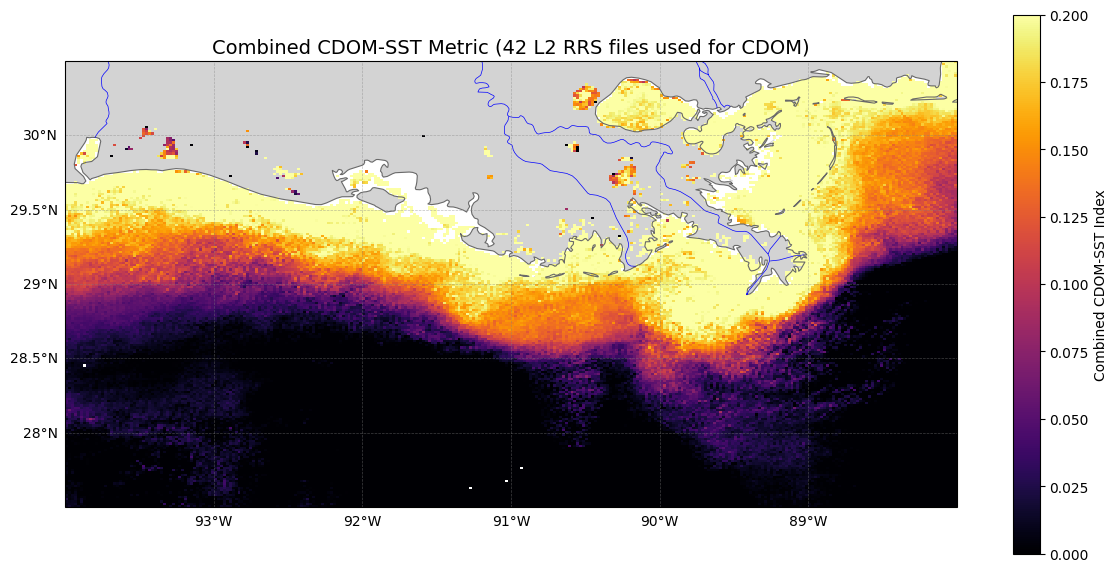

In [32]:
if 'binned_stat' in locals() and binned_stat.shape[0] > 0 and binned_stat.shape[1] > 0:
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Set the map extent using the bounding box
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # Plot the raster data
    cmin_plot = 0  # Example, adjust as needed
    cmax_plot = 0.2 # Example, adjust as needed
    
    raster = ax.pcolormesh(
        lon_grid, lat_grid, binned_stat,
        cmap='inferno', shading='auto',
        transform=ccrs.PlateCarree(),
        vmin=cmin_plot, vmax=cmax_plot
    )

    # Add map features
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='dimGray')
    ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)
    ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='dimGray')
    ax.add_feature(cfeature.RIVERS, linewidth=0.5, edgecolor='blue')
    
    # Add gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    # Colorbar and title
    plt.colorbar(raster, label='Combined CDOM-SST Index', shrink=0.7)
    num_files_processed = len(nc_files_rrs) if 'nc_files_rrs' in locals() else 0
    plt.title(f"Combined CDOM-SST Metric ({num_files_processed} L2 RRS files used for CDOM)", fontsize=14)
    
    plt.tight_layout()
    plt.show()
else:
    print("No binned data to plot.")

### Selective NaN Interpolation (Optional)

This section demonstrates using the `SelectiveInterpolator` to fill small gaps (NaNs) in the binned data, potentially improving visual continuity while preserving larger NaN regions.

Selective NaN interpolation complete for combined metric (threshold: 32 bins).


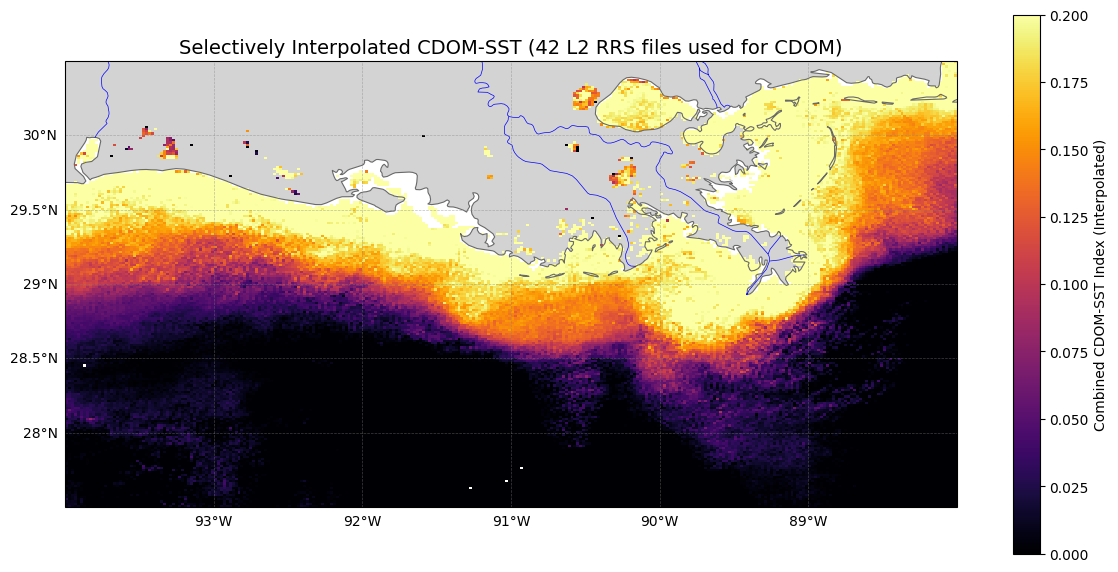

Selective NaN interpolation complete for CDOM (threshold: 32 bins).
Selective NaN interpolation complete for SST (native coords) (threshold: 32 bins).


In [ ]:
# Initialize interpolated data variables
stat_selective_interp = np.array([[]])
cdom_selective_interp = np.array([[]])
sst_selective_interp_native = np.array([[]])

interpolation_threshold = 32  # Regions with fewer connected NaN bins than this will be interpolated

# Interpolation for Combined Metric (on RRS grid)
if 'binned_stat' in locals() and binned_stat.shape[0] > 0 and binned_stat.shape[1] > 0 and lat_edges is not None and lon_edges is not None:
    stat_selective_interp = SelectiveInterpolator.interpolate(
        binned_stat, lat_edges, lon_edges, threshold=interpolation_threshold
    )
    print(f"Selective NaN interpolation complete for combined metric (threshold: {interpolation_threshold} bins).")

    # Plotting the selectively interpolated combined metric data
    fig_interp = plt.figure(figsize=(12, 8))
    ax_interp = plt.axes(projection=ccrs.PlateCarree())
    ax_interp.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    if 'cmin_plot' not in locals() or 'cmax_plot' not in locals():
        print("Warning: cmin_plot/cmax_plot not found from previous cell, using defaults for combined metric plot.")
        cmin_plot = 0 
        cmax_plot = 0.2 
        
    raster_interp = ax_interp.pcolormesh(
        lon_edges, lat_edges, stat_selective_interp, # Use 1D edges
        cmap='inferno', shading='auto',
        transform=ccrs.PlateCarree(),
        vmin=cmin_plot, vmax=cmax_plot 
    )
    ax_interp.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='dimGray')
    ax_interp.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)
    ax_interp.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='dimGray')
    ax_interp.add_feature(cfeature.RIVERS, linewidth=0.5, edgecolor='blue')
    gl_interp = ax_interp.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                    linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl_interp.top_labels = False; gl_interp.right_labels = False
    plt.colorbar(raster_interp, label='Combined CDOM-SST Index (Interpolated)', shrink=0.7)
    num_files_processed_rrs = len(nc_files_rrs) if 'nc_files_rrs' in locals() else 0
    plt.title(f"Selectively Interpolated CDOM-SST ({num_files_processed_rrs} L2 RRS files used for CDOM)", fontsize=14)
    plt.tight_layout(); plt.show()
else:
    print("No binned data available for selective interpolation of combined metric, or grid not available.")

# Interpolation for CDOM (on RRS grid)
if 'binned_cdom_raw' in locals() and binned_cdom_raw.shape[0] > 0 and binned_cdom_raw.shape[1] > 0 and lat_edges is not None and lon_edges is not None:
    cdom_selective_interp = SelectiveInterpolator.interpolate(
        binned_cdom_raw, lat_edges, lon_edges, threshold=interpolation_threshold
    )
    print(f"Selective NaN interpolation complete for CDOM (threshold: {interpolation_threshold} bins).")
else:
    print("Skipping CDOM interpolation, no binned CDOM data or RRS grid not available.")
        
# Interpolation for SST (on SST native grid)
if 'binned_sst_native' in locals() and binned_sst_native.shape[0] > 0 and binned_sst_native.shape[1] > 0 and lat_edges_sst_native is not None and lon_edges_sst_native is not None:
    sst_selective_interp_native = SelectiveInterpolator.interpolate(
        binned_sst_native, lat_edges_sst_native, lon_edges_sst_native, threshold=interpolation_threshold
    )
    print(f"Selective NaN interpolation complete for SST (native coords) (threshold: {interpolation_threshold} bins).")
else:
    print("Skipping SST (native coords) interpolation, no binned native SST data or SST native grid not available.")

### Plotting Interpolated CDOM

The binned and selectively interpolated CDOM data is visualized on a map.

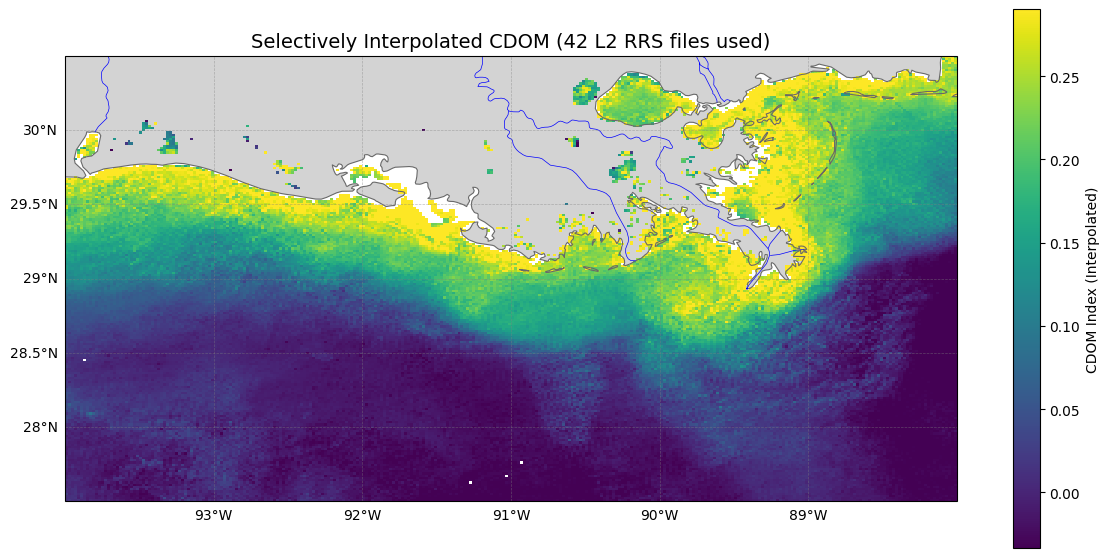

In [ ]:
if 'cdom_selective_interp' in locals() and cdom_selective_interp.shape[0] > 0 and cdom_selective_interp.shape[1] > 0 and lon_grid is not None and lat_grid is not None:
    fig_cdom = plt.figure(figsize=(12, 8))
    ax_cdom = plt.axes(projection=ccrs.PlateCarree())
    ax_cdom.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    valid_cdom_values = cdom_selective_interp[~np.isnan(cdom_selective_interp)]
    if valid_cdom_values.size > 0:
        vmin_cdom = np.percentile(valid_cdom_values, 5)
        vmax_cdom = np.percentile(valid_cdom_values, 95)
        if vmin_cdom >= vmax_cdom:
            vmin_cdom = np.nanmin(valid_cdom_values)
            vmax_cdom = np.nanmax(valid_cdom_values)
        if vmin_cdom == vmax_cdom:
            vmin_cdom -= 0.01 
            vmax_cdom += 0.01
    else:
        vmin_cdom = 0 
        vmax_cdom = 0.1 

    raster_cdom = ax_cdom.pcolormesh(
        lon_edges, lat_edges, cdom_selective_interp, # Use 1D edges
        cmap='viridis', shading='auto', 
        transform=ccrs.PlateCarree(),
        vmin=vmin_cdom, vmax=vmax_cdom
    )

    ax_cdom.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='dimGray')
    ax_cdom.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)
    ax_cdom.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='dimGray')
    ax_cdom.add_feature(cfeature.RIVERS, linewidth=0.5, edgecolor='blue')

    gl_cdom = ax_cdom.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl_cdom.top_labels = False
    gl_cdom.right_labels = False
    
    plt.colorbar(raster_cdom, label='CDOM Index (Interpolated)', shrink=0.7)
    num_files_processed = len(nc_files_rrs) if 'nc_files_rrs' in locals() else 0
    plt.title(f"Selectively Interpolated CDOM ({num_files_processed} L2 RRS files used)", fontsize=14)
    
    plt.tight_layout()
    plt.show()
else:
    print("No selectively interpolated CDOM data to plot or RRS grid not available.")

### Plotting Interpolated SST

The binned and selectively interpolated Sea Surface Temperature (SST) data is visualized on a map.

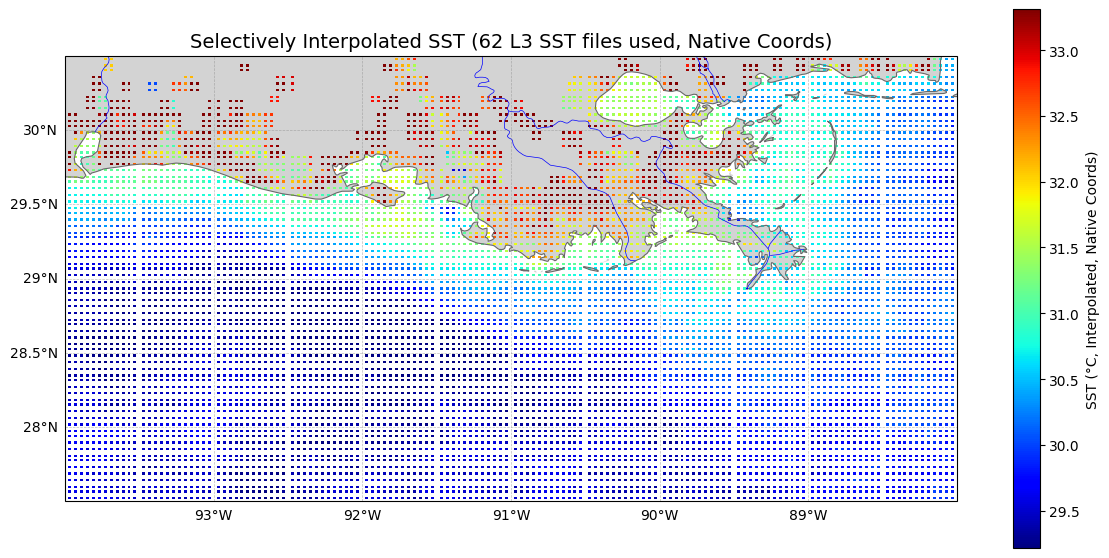

In [ ]:
if 'sst_selective_interp_native' in locals() and sst_selective_interp_native.shape[0] > 0 and sst_selective_interp_native.shape[1] > 0 and lon_grid_sst_native is not None and lat_grid_sst_native is not None:
    fig_sst = plt.figure(figsize=(12, 8))
    ax_sst = plt.axes(projection=ccrs.PlateCarree())
    ax_sst.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    valid_sst_values = sst_selective_interp_native[~np.isnan(sst_selective_interp_native)]
    if valid_sst_values.size > 0:
        vmin_sst = np.percentile(valid_sst_values, 5) 
        vmax_sst = np.percentile(valid_sst_values, 95)
        if vmin_sst >= vmax_sst:
            vmin_sst = np.nanmin(valid_sst_values)
            vmax_sst = np.nanmax(valid_sst_values)
        if vmin_sst == vmax_sst:
            vmin_sst -= 0.5 
            vmax_sst += 0.5
    else:
        vmin_sst = 15 
        vmax_sst = 35
        
    raster_sst = ax_sst.pcolormesh(
        lon_edges_sst_native, lat_edges_sst_native, sst_selective_interp_native, # Use 1D edges
        cmap='jet', shading='auto', 
        transform=ccrs.PlateCarree(),
        vmin=vmin_sst, vmax=vmax_sst
    )

    ax_sst.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='dimGray')
    ax_sst.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)
    ax_sst.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='dimGray')
    ax_sst.add_feature(cfeature.RIVERS, linewidth=0.5, edgecolor='blue')

    gl_sst = ax_sst.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                              linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl_sst.top_labels = False
    gl_sst.right_labels = False
    
    plt.colorbar(raster_sst, label='SST (°C, Interpolated, Native Coords)', shrink=0.7) # Assuming SST is in Celsius
    num_files_processed_sst = len(nc_files_sst) if 'nc_files_sst' in locals() else 0 # Number of L3 SST files
    plt.title(f"Selectively Interpolated SST ({num_files_processed_sst} L3 SST files used, Native Coords)", fontsize=14)
    
    plt.tight_layout()
    plt.show()
else:
    print("No selectively interpolated native SST data to plot or SST native grid not available.")